# 1 - MNIST MLP Network

Adapted from this tutorial -> 
https://www.machinecurve.com/index.php/2019/07/27/how-to-create-a-basic-mlp-classifier-with-the-keras-sequential-api/

`github.com/samph4`

~

#### Preface

By the end of this notebook you (hopefully) should have been able to make a neural network that you get to play around with. It will use a popular dataset known as the MNIST handwritten digits http://yann.lecun.com/exdb/mnist/ which is essentially a massive database containing 60,000 images of handwritten numeric digits from 0-9. We are going to create and train a classification network that will allow you to input a handwritten digit and the trained model should be able to predict or 'classify' what digit it is that you input to the network. 

It should be noted at this point that there are many different kinds of neural networks that have been designed to deal with a whole range of applications amidst different problem spaces from natural language processing to self driving cars etc etc. But we'll start with what is often considered the most simple of neural networks known as the Multi-layer percepron network - a diagram of which is shown below!

![Image](Figures\\mlp.png)

These networks are excellent at making a prediction (or number of predictions), based on a number of inputs. Simply put, the MLP is a layered network where each layer consists of a number of nodes. These nodes are often referred to as Perceptrons (hence multi-layer perceptron) and they can be thought of as a place where computation occurs (see left image). These nodes take a series of inputs and convert them into a single output. Each node has two important parameters to consider known as a 'weight' and a 'bias'. A weight is something that is specific to each input that enters the node: a numeric input enters the node and is multiplied by its associated numeric weight. The sum of all of the inputs multiplied by their associated weights is summed at the node. At this point, a 'bias' is another quantity that is added to the node to modify its output. That output then passes through an activation function (we'll get to this later) and then depending on how the network is arranged that output will enter a different node in a different layer as an input! During training, the values of these weights and biases are optimised such that their outputs begin to match more closely with the task you are trying to perform. During training, if the output from your network is drastically different to the value you want it to be (the target value), then you can expect the weights and biases to be optimised more rigorously than they would be if there was no difference between its output and its target value - but again I'll talk more about this later.

On the right hand side of the figure, you can see that a MLP network is typically split into three key sections:

* The input layer
* The hidden layer
* The output layer

The input layer, as you'd expect, is where the data is input to the network. Let's say for example we wanted to develop a network to predict somebodies mass based on their height, daily calorific intake and gender. Then a 3-element vector input to the network might look something like **[180, 2500, 0]** this (where 0 = male, 1 = female). The hidden layer is everything in between and os often reffered to as the 'black box' as it is less clear as to what the output from the nodes within this layer mean. They are the intermediary layers that the MLP uses on the way to predicting the actual output. Finally the output layer is simply the output, and the number of nodes typically corresponds to the number of outputs (or predictions) the MLP model is making. So for our example given an input of [180, 2500, 0]; we might expect a trained model to return an output (prediction) of **[80]** to represent 80kg.

~

## Coding a MLP network in Keras

We use the MNIST database, which stands for Modified National Institute of Standards and Technology (LeCun et al., 1998). It is one of the standard datasets that is used throughout the machine learning community, often for educational purposes.

In simple English, it’s just a database of handwritten numbers that are 28 by 28 pixels. They’ve been used in the early days of neural networks in one of the first practical applications of AI, being a digit recognizer for handwritten numbers. More information on MNIST is available here.

And this is what these numbers look like:

![Image](Figures\\mnist1.png)

#### Import Necessary Libraries

In [1]:
import keras                            #keras library that gives us access to a bunch of machine learning functions
from keras.datasets import mnist        #keras module has a bunch of datasets that we can import directly
from keras.models import Sequential     #sequential model lets us develop networks in sequence (in layers)
from keras.layers import Dense          #Dense is the name Keras gives to a fully connected layer of nodes
from keras.utils import to_categorical  #will make sense later!

import matplotlib.pyplot as plt         #matplotlib is a library that lets us plot graphs like MATLAB would.

Using TensorFlow backend.


#### Loading your data

Here we can assign some configuration variables:

In [2]:
# Configuration Options
feature_vector_length = 784
num_samples = 60000
num_classes = 10                 # digit can either be one of 10 values, from 0, 1, 2, 3, ..., 8, 9.

So this is a little weird. MLPs are good at mapping a bunch of inputs to a bunch of outputs. They wouldn't be your first choice when working with image data but I found this example and thought it was more interesting than some of the others. Typically you would use something called a Convolutional Neural Network (CNN) which we'll get too next, so we need to do something a little funky and flatten the pixel data by converting it from 28 x 28 pixel to a single vector. Hence why feature_vector_length was labeled as 784 since 28 * 28 = 784. Explained more here:

> "One MNIST sample is an image of 28 by 28 pixels. An interesting observation that I made a while ago is that MLPs don’t support multidimensional data like images natively. What you’ll have to do is to flatten the image, in the sense that you’ll just take all the rows and put them into a massive row. Since 28 times 28 is 784, our feature vector (which with the Pima dataset SLP was only 8) will contain 784 features (pixels)." -  https://www.machinecurve.com/index.php/2019/07/27/how-to-create-a-basic-mlp-classifier-with-the-keras-sequential-api/

The MNIST dataset has 60,000 images in its training set hence the number of samples is set at 60,000. We can confirm this below.

In [3]:
# Load the data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print(f'X_train shape is ',X_train.shape)

X_train shape is  (60000, 28, 28)


Here we used the mnist.load_data function and the function is written (thanks Keras) such that we can extract the training data and test data directly. `X` and `Y` are simply conventions that are typically used to refer to the input and output data. Obviously you can call them whatever you like, but `X` tends to be used to refer to the input data and `Y` refers to the output data (or target data). So to reiterate, `X_train` and `Y_train` contain the data used to train the network where for a given sample within X_train, the correct output (prediction) is found in the corresponding sample in `Y_train`. Similarly, the same goes for `X_test`, and `Y_test`. However this data is not used during training and is used to test the model once it has been trained on data that it has not been trained on / seen before; hence test data! 

You can also see that I wrote `X_train.shape`, the .shape part is a built in function in Python to show the shape of the variable. We can see that the variable has 3 dimensions (60000, 28, 28) that refers to 60,000 samples in the dataset where each sample is a 28x28 matrix containing pixel data.

#### Interact/Visualise the training Data

We can use the `matplotlib` module to display some of the images from the MNIST dataset. Play around with the code below. The [0] is simply indexing the first sample out of 60,000 from within the dataset. So replacing that with any number between [0, 59999] should be fine. Then the bit of code below I wrote just to show you how can you plot more images at the same time.

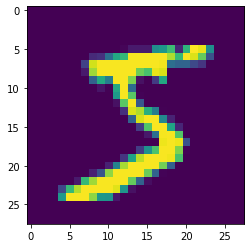

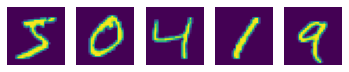

In [4]:
# Visualize one sample
plt.imshow(X_train[0])
plt.show()

# Visualize range of samples
n = 5

for i in range(n):
    plt.subplot(1,n,i+1)
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()

#### Sorting the X (feature) data

In [5]:
# Reshape the data - MLPs do not understand such things as '2D'.
# Reshape to 28 x 28 pixels = 784 features
X_train = X_train.reshape(X_train.shape[0], feature_vector_length)
X_test = X_test.reshape(X_test.shape[0], feature_vector_length)

When we used the `mnist.load_data()` function, the X elements represent the feature vectors (which at that point in time are still 28×28 pixels); the Y elements represent the targets (at that point still being numbers, i.e. 0-9). We can therefore use the `.reshape` function to change the shape of the vector. We reshape it such that the 28x28 image is flattened into a single vector of size 784. Remember that in python the first index in a variable is 0, whereas in MATLAB it is 1. Remember that `X_train.shape` returned (60000, 28,28), therefore `X_train[0]` = 60,000, `X_train[1]`= 28 and finally `X_train[2]` also equals 28. We can therefore change the shape of `X_train` (reshape it) by calling `X_train.reshape(60,000, 784)` which is identical to `X_train.reshape(X_train.shape[0], feature_vector_length)`.

In [6]:
# np.max(a) prints the maximum value in 'a'.
print(f'Maximum value in X_train is',np.max(X_train))

# Convert into greyscale
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Maximum value in X_train is 255


`.astype` is a function used to change the type of variable. Here we assure that the training data are `float.32` variables which refers to a decimal with a specific degree of precision. 

The next part simply converts the data into grayscale. The RGB colour space is often referred to as RGB 256. The red, green and blue use 8 bits each, which have integer values from 0 to 255. 0 typically corresponds to black and 255 to white. We can therefore divide all of the training data by 255 to scale the output between 0 and 1.

#### Sorting the Y (target) data

Lets take a quick look at what the `Y_train` data looks like. By calling `Y_train[0:10]` we can print some of the initial elements.

In [7]:
Y_train[0:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

We see that the data corresponds directly to the value of the handwritten digit in scalar form from 0-9. I'll take a slight detour here because when we're training the model the loss function that we are going to use is called `categorical cross entropy`. This is another example the guy uses to explain the idea a little better:

>"For those problems, we need a loss function that is called categorical crossentropy. In plain English, I always compare it with a purple elephant 🐘. Suppose that the relationships in the real world (which are captured by your training date) together compose a purple elephant (a.k.a. distribution). We next train a machine learning model that attempts to be as accurate as the original data; hence attempting to classify data as that purple elephant. How well the model is capable of doing that is what is called a loss, and the loss function allows one to compare one distribution (elephant) with the other (hopefully the same elephant). Cross entropy allows one to compare those. We can’t use the binary variant (it only compares two elephants), but need the categorical one (which can compare multiple elephants). This however requires us to ‘lock’ the set of elephants first, to avoid that another one is added somehow. This is called categorical data: it belongs to a fixed set of categories" ~(Chollet, 2017).

However, the MNIST targets here are just numbers and are not categorical. Here we can use the `to_categorical` function that we imported earlier to turn the numbers into categorical data. Therefore, rather than the target values being scalars [0, 9], one target vector will subseqently look as follows:

![Image](Figures\\categorical2.png)

This refers to a target value of 5.

In [8]:
# Convert target classes to categorical ones
Y_train = to_categorical(Y_train, num_classes)
Y_test = to_categorical(Y_test, num_classes)

Y_train[0,:]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

#### Creating the MLP

Here we will actually start to define the architecture of the MLP network. But this part shouldn't be scary, the most important part is making sure that we have a clear idea as to what is going into the network (input) and what is going out of it (the output). We have already spent a lot of time manipulating the data so we should already have a good understanding of the basic shape of the MLP network. We want it to take an image as input and give us the classification as output. We know that each image has been flattened into a feature vector of size 784 (28x28 pixels) so therefore the input to the network will have 784 nodes; and we know that the output will be the categorical vector described earlier containing 10 classes [0-9].

In [9]:
# Set the input shape
input_shape = (feature_vector_length,)
print(f'Feature shape: {input_shape}')

Feature shape: (784,)


Here we explicitly define the length of the input to the MLP network. This looks a little weird because we already defined the feature_vector_length to be 784 (28x28) so couldn't we just use the same thing? The answer is yes you could, but this is slightly better practice. Here we use the notation `(feature_vector_length,)`, and take note of the comma. This changes the variable type from numeric to something called a **tuple**. 

> A tuple is a collection of objects which ordered and immutable. Tuples are sequences, just like lists. The differences between tuples and lists are, the tuples cannot be changed unlike lists and tuples use parentheses, whereas lists use square brackets. - https://www.tutorialspoint.com/python/python_tuples.htm

Basically they contain data that cannot be changed, so here we are just saying that the input to the MLP network is of size 784 and will not change. In the cell block below, we can create the MLP network!

In [10]:
# Create the model
model = Sequential()
model.add(Dense(350, input_shape=input_shape, activation='relu')) # Layer 1 (input and first layer)
model.add(Dense(50, activation='relu'))                           # Layer 2
model.add(Dense(num_classes, activation='softmax'))               # Layer 3 (output)

So there's a few things happening here but we'll go through each line and it will make more sense. So first we define the model type by writing `model = Sequential()`. 

> "The sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. - https://keras.io/guides/sequential_model/

So since we are creating a MLP network and there is a clear input and output tensor, a sequential model is suitable. By calling `model = Sequential()`, we create a variable named `model` which will contain all of the information regarding the model that we create. 

At this point, we can add additional layers directly by calling `.add` on the model variable directly. Keras gives access to a whole bunch of different layers that you can use and play around with to do different things (https://keras.io/api/layers/), but here we use the Dense layer which means that all of the nodes in that layer will be fully connected (densely connected) to the nodes in the next layer. When we create a dense layer, we need to define a few properties - how many nodes we want in the layer, if it is the first layer we have added we need to define the input shape, and finally the activation function used to modulate the output before it passes into the next layer. So if we consider the first layer `model.add(Dense(350, input_shape=input_shape, activation='relu'))`, we can see that a dense layer has been added and it has 350 nodes. Since it is the first layer we define `input_shape=input_shape` (we named the variable `input_shape` previously and it matches, but it could have been named anything) and finally we define a 'relu' activation function (will get to shortly). The second layer is defined in a similar fashion but this time has 50 nodes instead and also uses the 'relu' activation function. Then finally we define the output layer with `model.add(Dense(num_classes, activation='softmax'))`, where `num_classes` here defines the size of the output layer.

*Activation Functions* - regarding activation functions, it's best to redirect you to this link because it does a good job of explaining what they are and their different types (https://medium.com/the-theory-of-everything/understanding-activation-functions-in-neural-networks-9491262884e0). The important thing to know is that they are used to modulate the output of a node before it passes further into the network. So for example, the `relu` function refers to a REctified Linear Unit (ReLU) that simply allows positive values to pass through unchanged and replaces any negative values with 0. Other functions include Sigmoid functions which moderate the output between [-1, 1]. Finally, the softmax activation function is useful because it will make the model return probabilities of the networks predictions for each class in the output. The probabilities of which will sum to a total of 1.

#### Training the model

Finally we can train the model. Once the model architecture has been defined (by determining the layers/arrangement etc), there is one final step. We need to compile the model as this lets us define the loss function, the optimizer and the metrics used to track the results of the training process. The `model.compile()` function is powerful and allows us to change and define lots of things about the training process; here we can select whichever loss function we like, we can use any optimiser and also use any metric we wish to judge the performance of the model (see https://keras.io/api/metrics/).

First, let's discuss the <ins>loss function</ins>:

> "The purpose of loss functions is to compute the quantity that a model should seek to minimize during training." - https://keras.io/api/losses/

The loss function is the function that the neural network is trying to minimise. The problem and data types you are working with will determine the loss function that you will use and that will make sense, there are many to choose from including probabilistic losses and regression losses etc. But here we use the `categorical_crossentropy` function as it computes the crossentropy loss between the labels and the predictions. We use this loss function when there are two or more label classes (we have 10). The function expects labels to be provided in a *one_hot* representation which is the format we arranged the Y (feature) data into using the `to_categorical` function - this means that [0,0,0,0,1,0,0,0,0,0] refers to the class 4 rather than the scalar value of 4 itself. This loss function performs well and that is why we took the extra step to assure the data was in this format. If we insisted that we want to provide labels as integers, we could have utilised the `SparseCategoricalCrossentropy` loss instead.

Next, we'll talk about the <ins>optimizer</ins>:

> "Optimizers are algorithms or methods used to change the attributes of your neural network such as weights and learning rate in order to reduce the losses. How you should change your weights or learning rates of your neural network to reduce the losses is defined by the optimizers you use." - https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6.

Again, there are many types of optimizers available and they are essentially optimization algorithms that we use for training neural networks. This is the part where it can get very mathsy and I would recommend having a brief read through the link above as it does a good job explaining how some of the different optimizers work. But ultimately the optimizer is responsible for updating the weights and biases of the neural network in an attempt to minimise the value computed by the loss function. Here we use the `adam` optimiser which has become very popular in machine learning applications and often yields favourable results. It is a good starting point - adam stands for Adaptive Moment Estimation.

Finally, we have <ins>metrics</ins>:

> "A metric is a function that is used to judge the performance of your model." - https://keras.io/api/metrics/

Metric functions are similar to loss functions, except that the results from evaluating a metric are not used when training the model. Note that you can use any loss function as a metric. Metrics are useful because they are stored within the model variable itself during training and we can access them once training has finished (or during training) to plot the results to get a better understanding as to what is happening durin gthe training process. We will do this later!

~

FInally we can call the `model.fit()` function to actually begin the training process and start optimising the weights and biases to suit the problem. Here we pass in the training data, `X_train` (feature data) and `Y_train` (target data) directly into the `.fit()` function. Next we define the number of epochs, this is essentially the stopping criteria and lets the model know that it should stop training once 20 epochs have passed.

> *What is an epoch?* ~ "An epoch is a term used in machine learning and indicates the number of passes of the entire training dataset the machine learning algorithm has completed. Datasets are usually grouped into batches (especially when the amount of data is very large). Some people use the term iteration loosely and refer to putting one batch through the model as an iteration." - https://radiopaedia.org/articles/epoch-machine-learning

Recall that the dataset consists of 60,000 samples - here we define `batch_size=250`, this means that for each iteration 250 samples are passed into the model. Larger batch sizes means that the model will take less time to train, but is dependent on the hardware you have available. Although not always necessary (depending on size of the problem) it is preferred to use GPUs to train neural networks, as the parellilsation capabilities of the graphics card architecture allow them to compute through batch data much more efficiently than CPUs (but that's another topic in itself). If ever your machine has issues running a model, a good first step might be to try lowering the batch_size. `verbose=1` simply gives us a pretty animated progress bar for when we're training the model, conversely setting `verbose=0` will output nothing (this happens by default). Finally, we can split some of the training dataset into a validation set used to evaluate the network further after training. The `validation_split=0.2` statement within the `.fit()` function allocates 20% of the training set for validation purposes. Running the cell below will begin training!

In [11]:
# Configure the model and start training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=20, batch_size=250, verbose=1, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 1s 19us/step - loss: 0.3776 - accuracy: 0.8935 - val_loss: 0.1714 - val_accuracy: 0.9514
Epoch 2/20
48000/48000 [==============================] - 1s 12us/step - loss: 0.1451 - accuracy: 0.9583 - val_loss: 0.1318 - val_accuracy: 0.9614
Epoch 3/20
48000/48000 [==============================] - 1s 11us/step - loss: 0.1001 - accuracy: 0.9712 - val_loss: 0.1058 - val_accuracy: 0.9694
Epoch 4/20
48000/48000 [==============================] - 1s 11us/step - loss: 0.0722 - accuracy: 0.9789 - val_loss: 0.0884 - val_accuracy: 0.9728
Epoch 5/20
48000/48000 [==============================] - 1s 13us/step - loss: 0.0539 - accuracy: 0.9845 - val_loss: 0.0863 - val_accuracy: 0.9751
Epoch 6/20
48000/48000 [==============================] - 0s 10us/step - loss: 0.0417 - accuracy: 0.9882 - val_loss: 0.0886 - val_accuracy: 0.9746
Epoch 7/20
48000/48000 [==============================] - 1s 10us/st

#### Results and Evaluation!

Now the model has been trained and we can evaluate the results and play around with the trained model. I mentioned earlier that the metrics during trained are saved within the model variable itself, accessing them is not the most intuitive honestly, but by calling `dir(model)` you will see a big list of all the attributes you can call from that variable. One of them is history, within that we can call a secondary history attribute that stores all of the metrics stored during training. We can then plot these values using the `matplotlib` library which stores works in a very similar way to MATLAB.

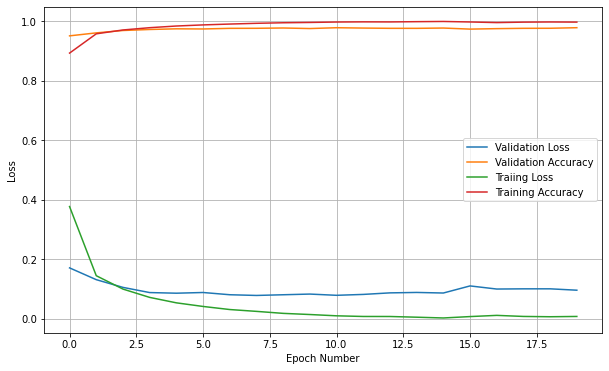

In [13]:
plt.figure(figsize=(10,6))
plt.plot(range(20),model.history.history['val_loss'], label='Validation Loss')
plt.plot(range(20),model.history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(range(20),model.history.history['loss'], label='Traiing Loss')
plt.plot(range(20),model.history.history['accuracy'], label='Training Accuracy')

# some simple formatting
plt.legend()
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid('True')
plt.show()

As you can see, training loss decreases rapidly (noted by the steep gradient). This is perfectly normal, as the model always learns most during the early stages of optimization. Accuracies converge after only one epoch, and still improve during the 10th, albeit slightly.

Validation loss is also still decreasing during the 10th epoch. This means that although the model already performs well (accuracies over 97%!), it can still improve further without losing its power to generalize to data it has never seen. In other words, our model is still underfit… perhaps, increasing the number of epochs until validation loss increases again might yield us an even better model.

However, this was all observed from validation data. What’s best is to test it with the actual testing data that was generated earlier. Here we call the `model.evaluate` function and input the test data we created earlier, `X_test` and `Y_test`. Once again we can use the verbose feature to display the progress output and print the results.

In [14]:
# Test the model after training
test_results = model.evaluate(X_test, Y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

10000/10000 [==============================] - 0s 38us/step
Test results - Loss: 0.08209362221146803 - Accuracy: 97.93000221252441%


The results show that the accuracy of the model was 97.64 % when evaluated on the test data that it had not been trained on! Obviously this is a good result, but people have managed to achieve more accurate results for this dataset and there are programming competitions and leaderboards on www.kaggle.com that offer cash prizes and incentives for those who can improve on the 'state of the art' models. We could modify size of the network, train the model for longer, perhaps add more layers, or use different optimisers, activation functions and loss functions in attempt to improve the accuracy of the network. A better method in this case though might be to use a different type of network alltogether; a popular choice might be a Convolutional Neural Network - but we'll get to that in the next notebook.

For now, lets play around with the model that we just trained and take a look at how we can use it to make new predictions! First of all, we can call the `model.predict()` function to use the model (as you might expect) to make a new prediction. We can simply pass a handwritten digit image in the same way as we did during training. But first, lets actually see what we are putting into the network so we know whether it gives us the right answer!

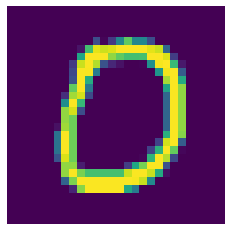

In [17]:
# reshaping the test data  into image format so that we can plot it - note the 28x28 pixels.
X_test = X_test.reshape(10000,28,28)

index = 10                            # which sample (index) should we take from the test dataset to evalutate!
test_input = X_test[index,:,:]        # [28x28] array containing image data for a single digit taken from the dataset.

# Visualize the sample we will put into the network!
plt.imshow(test_input)
plt.axis('off')
plt.show()

Note that we reshaped the data in the training set into pixel format so that we can plot it to have a look. Now we need to flatten it again so that it is in the format that that model expects i.e. a vector of 784 elements. We can do this easily by calling the `.reshape()` attribute once again before finally using `model.predict()`.

In [18]:
test_input = test_input.reshape(1, 784)
a = model.predict(test_input)
print(f'MLP output: ', a)

MLP output:  [[1.0000000e+00 2.4270717e-13 1.1487758e-11 4.3266337e-16 2.2956909e-11
  3.4349083e-14 1.3940132e-09 8.5837594e-11 1.2734755e-13 8.7076248e-09]]


Here you can see the output of the MLP network in its raw form based on the input of the handwritten digit. Due to the `softmax` activation layer we used in the output, the sum of the output vector equals 1. The vector is of length 10 corresponding to each of the possible classes (numbers from 0-9) that the number could be. We can therefore determine the models prediction by looking at the maximum value in this vector, in this case - the first element in the vector is the largest (by far) which corresponds to the number 0. Which is correct! This is good news, and the fact that this number was much larger is a testament to how confident the network is that this is in fact a number 0.

It is possible to visualise this in a better way using a bar chart, we will therefore be able to compare the predictions of the MLP network for any input MNIST digit for each possible class. Because the model was so successful, it was actually quite difficult to find a sample to input to the network to show this clearly. But the 8th sample worked nicely as it was quite ambiguos and I was unsure as to what number this was meant to be - you'll see that it looks like a number 6 but could probably also pass for a number 5. Run the code below and take a look at the output, take some time to change the `index` number and see how the bar graph changes for different MNIST digits.

NameError: name 'y_pos' is not defined

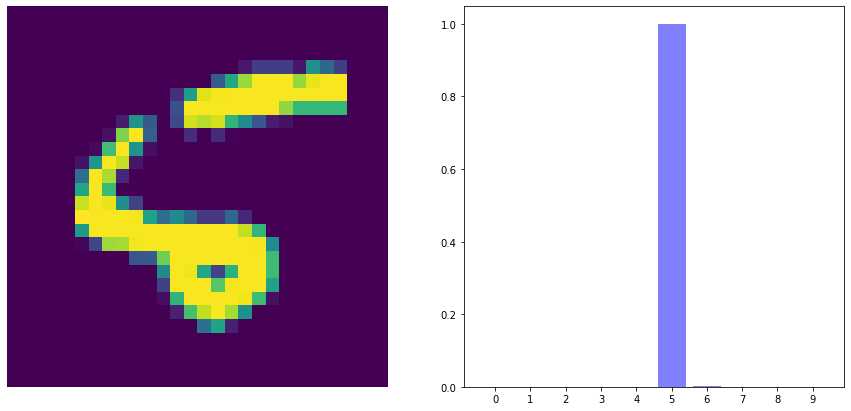

In [19]:
# reshape the image into a format the network understands
index = 8                             # which sample (index) should we take from the test dataset to evalutate!
test_input = X_test[index,:,:]        # [28x28] array containing image data for a single digit taken from the dataset.
test_input = test_input.reshape(1, 784)
a = model.predict(test_input)

# create subplot to show input and its prediction
plt.figure(figsize=(15,7))

# MNIST test input (1st subplot)
plt.subplot(1,2,1)
plt.imshow(test_input.reshape(28,28))
plt.axis('off')

# bar chart (2nd subplot)
plt.subplot(1,2,2)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
prediction = a[0,:].tolist() # convert prediction array into list to plot on chart

plt.bar(class_names, prediction, align='center', alpha=0.5, color='blue')
plt.xticks(y_pos, class_names)
plt.xlabel('MNIST Handwritten Digit Class')
plt.ylabel('Softmax prediction (Confidence)')
plt.title('Prediction of the MLP network trained on the MNIST handwritten digits dataset')

plt.show()

~ `Finished!`